In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [11]:
# I have loaded the Titanic dataset from a CSV file.
data = pd.read_csv('/content/train.csv')

In [12]:
# I have handled missing values in the dataset to ensure all features are complete.
imputer = SimpleImputer(strategy='mean')
data['Age'] = imputer.fit_transform(data[['Age']])
data['Fare'] = imputer.fit_transform(data[['Fare']])
data['Embarked'].fillna('S', inplace=True)

<ipython-input-12-5dcfb378549e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


In [13]:
# I have encoded the categorical variables ('Sex' and 'Embarked') into numeric values using LabelEncoder.
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [14]:
# I have prepared the features (X) and target (y) for model training.
# Features after dropping irrelevant columns: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked (7 features total)
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = data['Survived']

In [15]:
# I have split the dataset into training and validation sets to evaluate the model's performance.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# I have converted the datasets into DMatrix format, which is optimized for XGBoost computations.
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [17]:
# I have defined monotonic constraints to enforce domain knowledge.
# The constraint tuple must have the same length as the number of features (7 in this case).
# Features in order: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
# I applied a positive constraint to 'Fare' (index 5) to enforce that higher fares increase survival probability.
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
    'monotone_constraints': '(0,0,0,0,0,1,0)'  # 7 values for 7 features
}

In [18]:
# I have trained the XGBoost model with monotonic constraints.
# This ensures that the 'Fare' feature has a positive relationship with survival probability.
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=10
)

[0]	validation-logloss:0.63599
[1]	validation-logloss:0.60053
[2]	validation-logloss:0.57180
[3]	validation-logloss:0.54848
[4]	validation-logloss:0.52827
[5]	validation-logloss:0.51195
[6]	validation-logloss:0.49892
[7]	validation-logloss:0.48646
[8]	validation-logloss:0.47489
[9]	validation-logloss:0.46713
[10]	validation-logloss:0.45857
[11]	validation-logloss:0.45146
[12]	validation-logloss:0.44661
[13]	validation-logloss:0.44282
[14]	validation-logloss:0.43814
[15]	validation-logloss:0.43712
[16]	validation-logloss:0.43321
[17]	validation-logloss:0.43078
[18]	validation-logloss:0.42724
[19]	validation-logloss:0.42506
[20]	validation-logloss:0.42383
[21]	validation-logloss:0.42154
[22]	validation-logloss:0.42180
[23]	validation-logloss:0.42052
[24]	validation-logloss:0.42096
[25]	validation-logloss:0.42079
[26]	validation-logloss:0.42012
[27]	validation-logloss:0.42000
[28]	validation-logloss:0.42028
[29]	validation-logloss:0.42078
[30]	validation-logloss:0.42079
[31]	validation-lo

In [19]:
# I have made predictions on the validation set using the trained model.
y_pred_prob = bst.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)

In [20]:
# I have evaluated the model's performance using accuracy.
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.8156424581005587


<Figure size 1000x600 with 0 Axes>

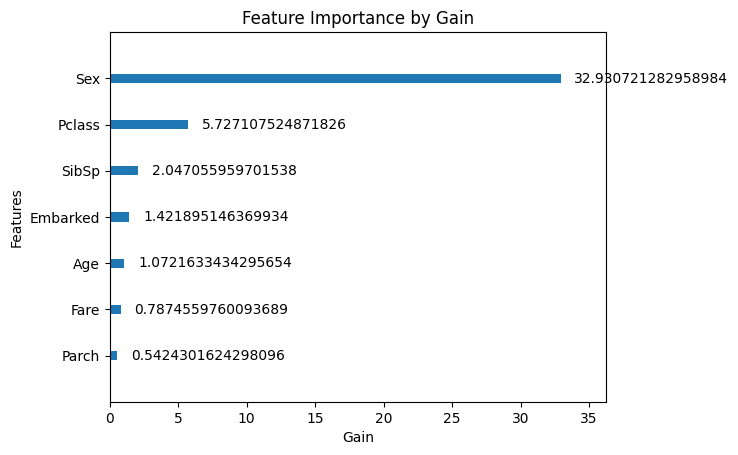

In [21]:
# I have visualized the feature importance to confirm the impact of the constrained feature ('Fare').
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type='gain', grid=False)
plt.title("Feature Importance by Gain")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()